In [1]:
# Make use of a mirror for the official MNIST website
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [2]:
# This disables SSL certificate verification for the current session which enable us
# to download the MNIST dataset without any problem.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Import of custom functions
from spcefic_sample_unleraning import selective_train_unlearning
from plot_generator import plot_accuracy, plot_loss, plot_confusion_matrix, plot_pca

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('./', train=True, download=True, transform=transform)
test_dataset = MNIST('./', train=False, transform=transform)

In [5]:
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [6]:
# Subset indices for class 6 and class 3
indices_6 = [i for i, (x, y) in enumerate(train_dataset) if y == 6]
indices_3 = [i for i, (x, y) in enumerate(train_dataset) if y == 3]

In [7]:
# Define the model
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [8]:
# Initialize model, loss, and optimizer
model = CustomNeuralNetwork()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [9]:
# Variables to store accuracy and loss for graphing later
train_acc = []
unlearn_acc = []
train_loss = []
unlearn_loss = []
epochs = list(range(1, 5))

In [10]:
# Train model on the dataset
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    correct = 0
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader.dataset)
    train_acc.append(accuracy)
    train_loss.append(avg_loss)
    print(f"Train Epoch: {epoch} Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

In [11]:
# Test model performance
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    y_pred = []  # To store all predictions
    y_true = []  # To store all true labels        
        
    with torch.no_grad():  # Disable gradient calculation for inference
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # Add batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            y_pred.extend(pred.view(-1).tolist())  # Store predictions, flatten tensor and convert to list
            y_true.extend(target.view(-1).tolist())  # Store true labels, flatten tensor and convert to list
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
    
    test_loss /= len(test_loader.dataset)  # Average loss per sample
    accuracy = 100. * correct / len(test_loader.dataset)  # Compute accuracy
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return accuracy, y_pred, y_true

In [12]:
# Train the model on the entire dataset first
for epoch in range(1, 5): 
    train(model, train_loader, criterion, optimizer, epoch)

Train Epoch: 1 Accuracy: 91.94%, Loss: 0.0042
Train Epoch: 2 Accuracy: 96.56%, Loss: 0.0018
Train Epoch: 3 Accuracy: 97.55%, Loss: 0.0012
Train Epoch: 4 Accuracy: 98.09%, Loss: 0.0010


In [13]:
# Test the model before unlearning
print("Testing pre-trained model:")
train_accuracy_before, y_pred_before, y_true_before = test(model, test_loader)

Testing pre-trained model:

Test set: Average loss: 0.0001, Accuracy: 9770/10000 (97.70%)



In [14]:
# Now for unlearning class 6 and learning class 3
# Freeze all weights except for the final layer
for param in model.fc1.parameters():
    param.requires_grad = False
for param in model.fc2.parameters():
    param.requires_grad = False

In [15]:
# Train with selective specific sample unlearning 
for epoch in range(1, 5):
    selective_train_unlearning(model, train_loader, optimizer, criterion, epoch, unlearn_acc, unlearn_loss)

Selective Unlearning Epoch: 1 Accuracy: 89.05%, Loss: 0.0545
Selective Unlearning Epoch: 2 Accuracy: 89.14%, Loss: 0.0341
Selective Unlearning Epoch: 3 Accuracy: 89.20%, Loss: 0.0325
Selective Unlearning Epoch: 4 Accuracy: 89.23%, Loss: 0.0314


In [16]:
# Test the model after unlearning
print("Testing model after unlearning:")
unlearn_accuracy_after, y_pred_after, y_true_after = test(model, test_loader)

Testing model after unlearning:

Test set: Average loss: 0.0015, Accuracy: 8836/10000 (88.36%)



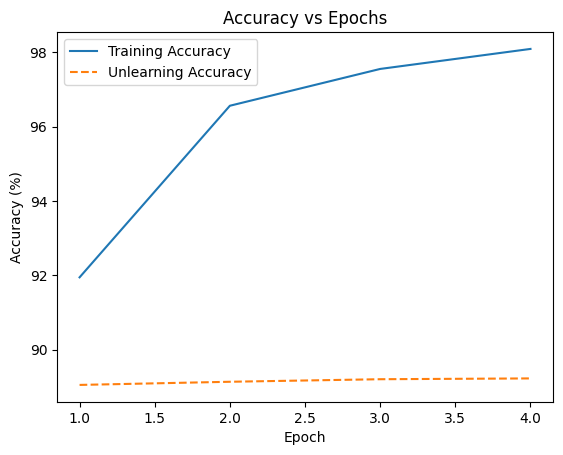

In [17]:
# Accuracy vs Epochs
plot_accuracy(train_acc, unlearn_acc, epochs)

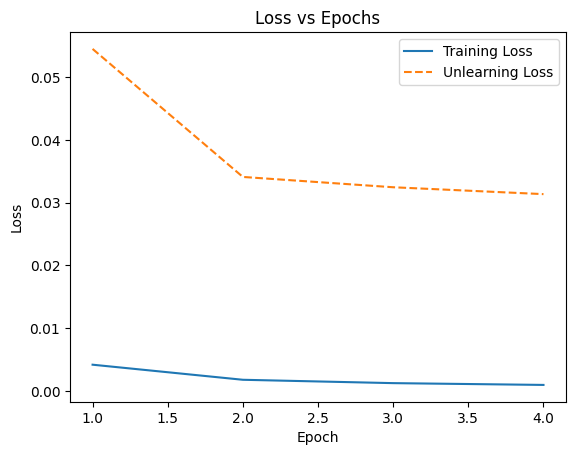

In [18]:
# Loss vs Epochs
plot_loss(train_loss, unlearn_loss, epochs)

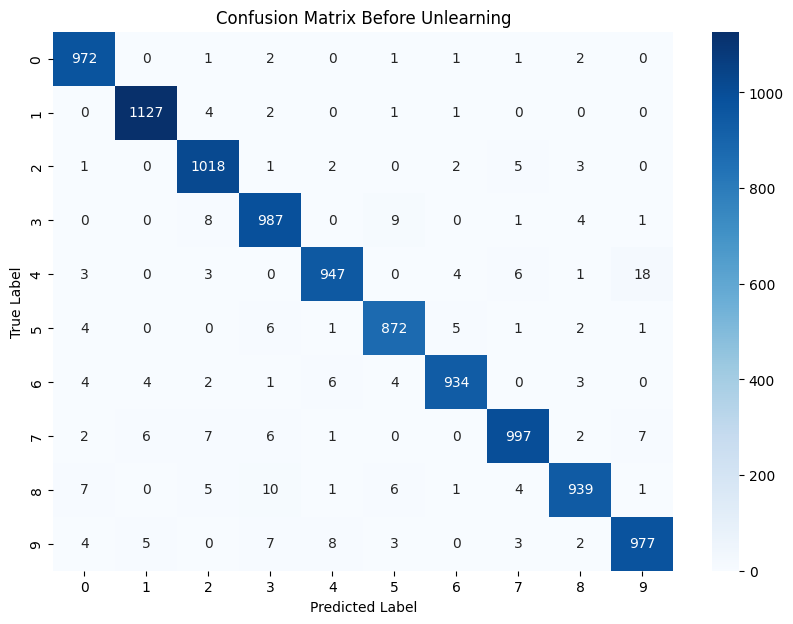

In [19]:
# Collect predictions and plot confusion matrix BEFORE unlearning
plot_confusion_matrix(y_true_before, y_pred_before, title="Confusion Matrix Before Unlearning")

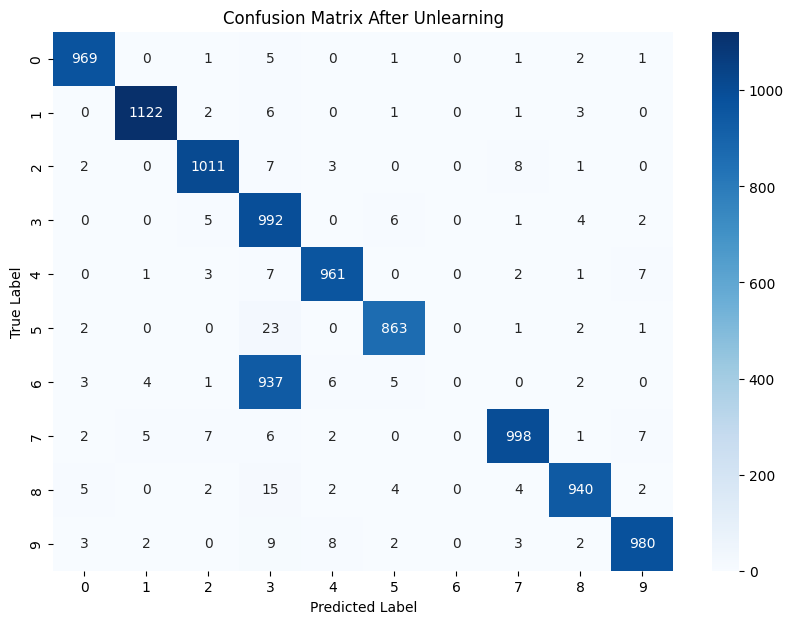

In [20]:
plot_confusion_matrix(y_true_after, y_pred_after, title="Confusion Matrix After Unlearning")

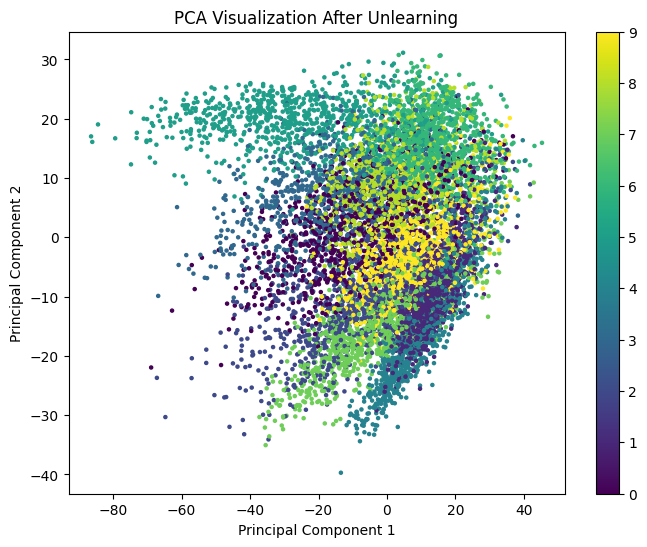

In [21]:
# Assume `features` is the output of the model and `labels` are the true labels
features = torch.cat([model(data).detach() for data, _ in test_loader], dim=0).cpu().numpy()
labels = torch.cat([target for _, target in test_loader], dim=0).cpu().numpy()

# Plot the PCA visualization
plot_pca(features, labels, title="PCA Visualization After Unlearning")